## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [53]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import WeightedRandomSampler
import os
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
import copy
import random
%matplotlib inline

In [54]:
random.seed = 123

In [55]:
# create CNN class 
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # model hyperparameters 
        self.epochs = 10
        self.batch_size = 16
        self.learning = 0.005
        self.momentum = 0.9
        self.decay = False
        
        # define network layers 
        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [56]:
# Create model using class 
model = CustomNeuralNetwork()

In [57]:
# Load data 
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
        
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((256, 256)),
    T.RandomSolarize(2, p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor()
])

training_data = XRayDataset(train_path, transforms) # apply transformations to test data set 
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)

train_dataloader = DataLoader(training_data, batch_size=model.batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=model.batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=model.batch_size, shuffle=True)

In [58]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=model.learning, momentum=model.momentum)
scheduler_lr = StepLR(optimizer, 
                   step_size = 4, # Period of learning rate decay
                   gamma = 0.5)

scheduler_eilr = ExponentialLR(optimizer, 
                          gamma = 0.5) # Multiplicative factor of learning rate decay.

In [59]:
# Train and validate the network
train_losses = []
train_accuracies = []
train_recalls = []
val_accuracies = []
val_recalls = []
val_losses = []

for epoch in range(model.epochs):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss += loss.item()
        y_true = np.concatenate((y_true, labels_tensor.numpy()))
        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        y_predict = np.concatenate((y_predict, y_pred_batch))
    
    epoch_accuracy = accuracy_score(y_true, y_predict)
    epoch_recall = recall_score(y_true, y_predict, average='binary')
    train_losses.append(running_loss)
    train_accuracies.append(epoch_accuracy)
    train_recalls.append(epoch_recall)

    #Learning decay
    if model.decay:
        scheduler_lr.step()

    #VALIDATION
    # if (epoch+1) % 5 == 0: 
    
    with torch.no_grad(): # don't keep track of the gradients in the validation part
        model.eval() 
        val_running_loss = 0.0
        y_true_val = np.array([])
        y_predict_val = np.array([])
        for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward pass
            label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
            labels_tensor = torch.tensor([label_dict[label] for label in labels])
            y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
            y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))
            val_loss = criterion(outputs, labels_tensor)  # calculate loss
            val_running_loss += val_loss.item()

        val_epoch_accuracy = accuracy_score(y_predict_val, y_true_val)
        val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
        val_losses.append(val_running_loss)
        val_accuracies.append(val_epoch_accuracy)
        val_recalls.append(val_epoch_recall)

In [ ]:
print("Training accuracies",train_accuracies)
print("Training recalls", train_recalls)
print("Training losses", train_losses)

print("Validation accuracies",val_accuracies)
print("Validation recalls", val_recalls)
print("Validation loss", val_losses)

Training accuracies [0.8716760185411075, 0.9151012442059039, 0.9309587704318126, 0.9412051719931691, 0.9443766772383508]
Training recalls [0.6946216955332726, 0.8040109389243391, 0.8422971741112124, 0.8787602552415679, 0.8732907930720146]
Training losses [79.4956025686115, 58.191087033133954, 47.18349031917751, 41.62682727444917, 37.41909887827933]
Validation accuracies [0.28448275862068967, 0.7482758620689656, 0.9275862068965517, 0.8068965517241379, 0.9344827586206896]
Validation recalls [1.0, 0.9272727272727272, 0.896969696969697, 0.9818181818181818, 0.8848484848484849]
Validation loss [171.76498889923096, 19.93375876545906, 8.774817526340485, 15.506244763731956, 5.640364609658718]


In [ ]:
#5. Test model
test_accuracies = []
test_recalls = []

with torch.no_grad():
    model.eval()
    y_true_test = np.array([])
    y_predict_test = np.array([])
    for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
        y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))

    test_epoch_accuracy = accuracy_score(y_true_test, y_predict_test)
    test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
    test_accuracies.append(test_epoch_accuracy)
    test_recalls.append(test_epoch_recall)

In [ ]:
print("test accuracy", test_accuracies)
print("test recall", test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


test accuracy [0.9575191163976211]
test recall [0.9003115264797508]
0.0: 870
1.0: 307


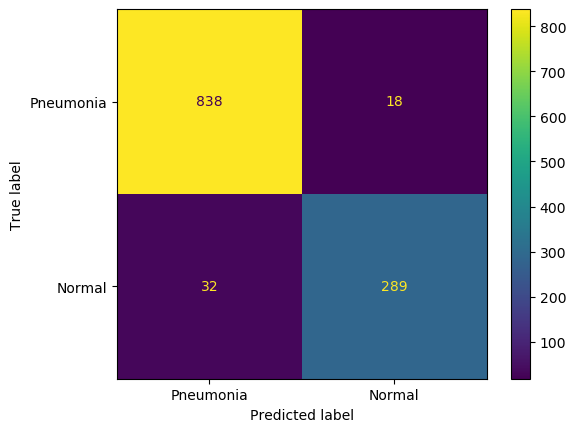

In [ ]:
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(y_true_test, y_predict_test)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pneumonia", "Normal"])
disp.plot()

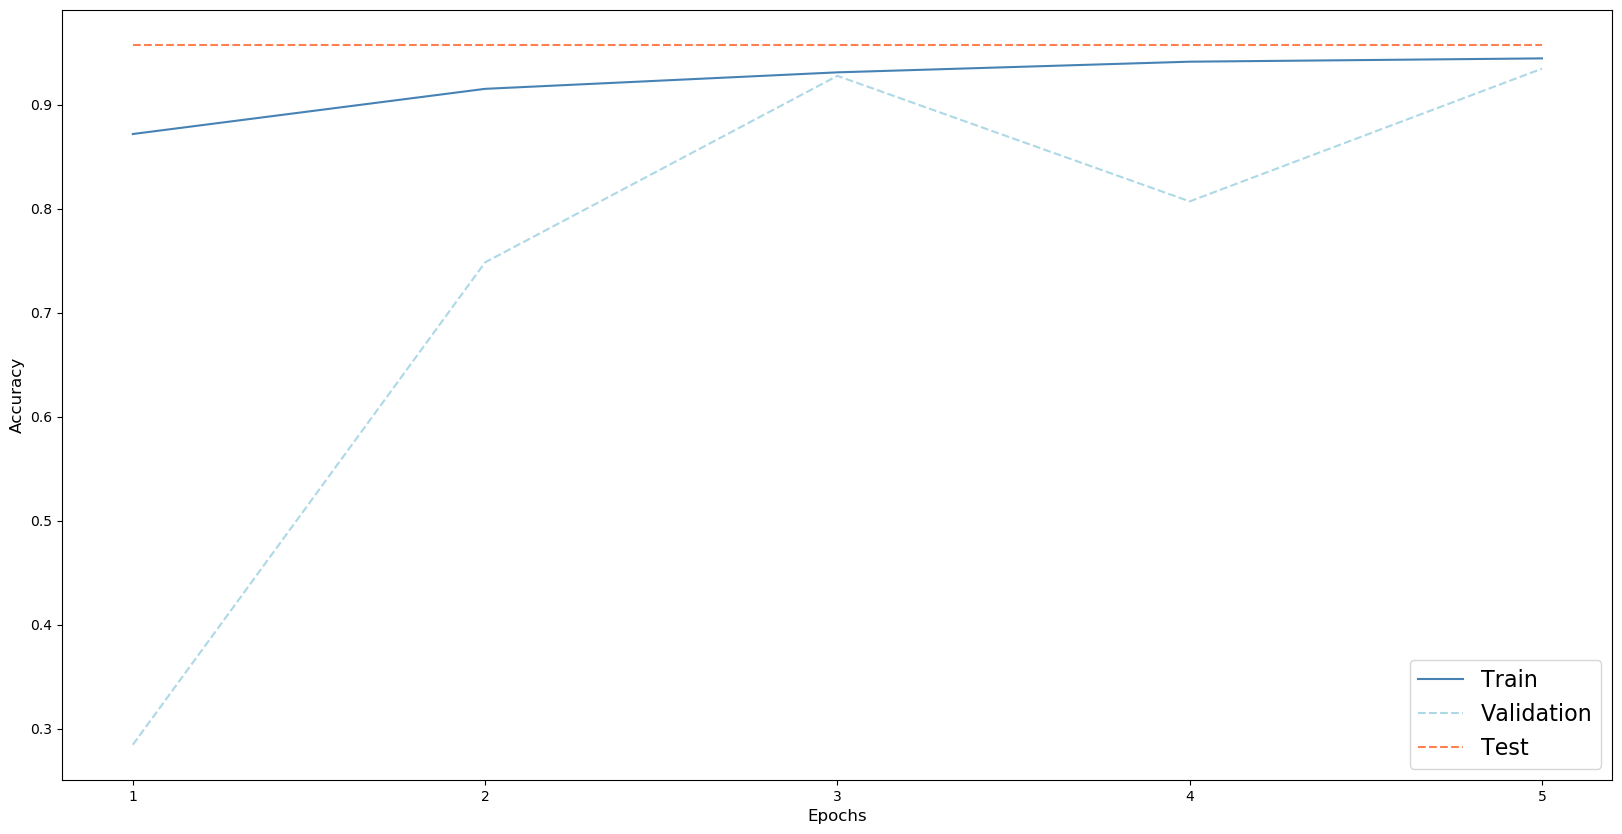

In [ ]:
test_accuracy =  test_accuracies * model.epochs
epochs = [i for i in range(1,model.epochs+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracy, color= "coral", ls='dashed', label='Test')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
# ax.set_title("Accuracy", fontsize=16)
plt.show()

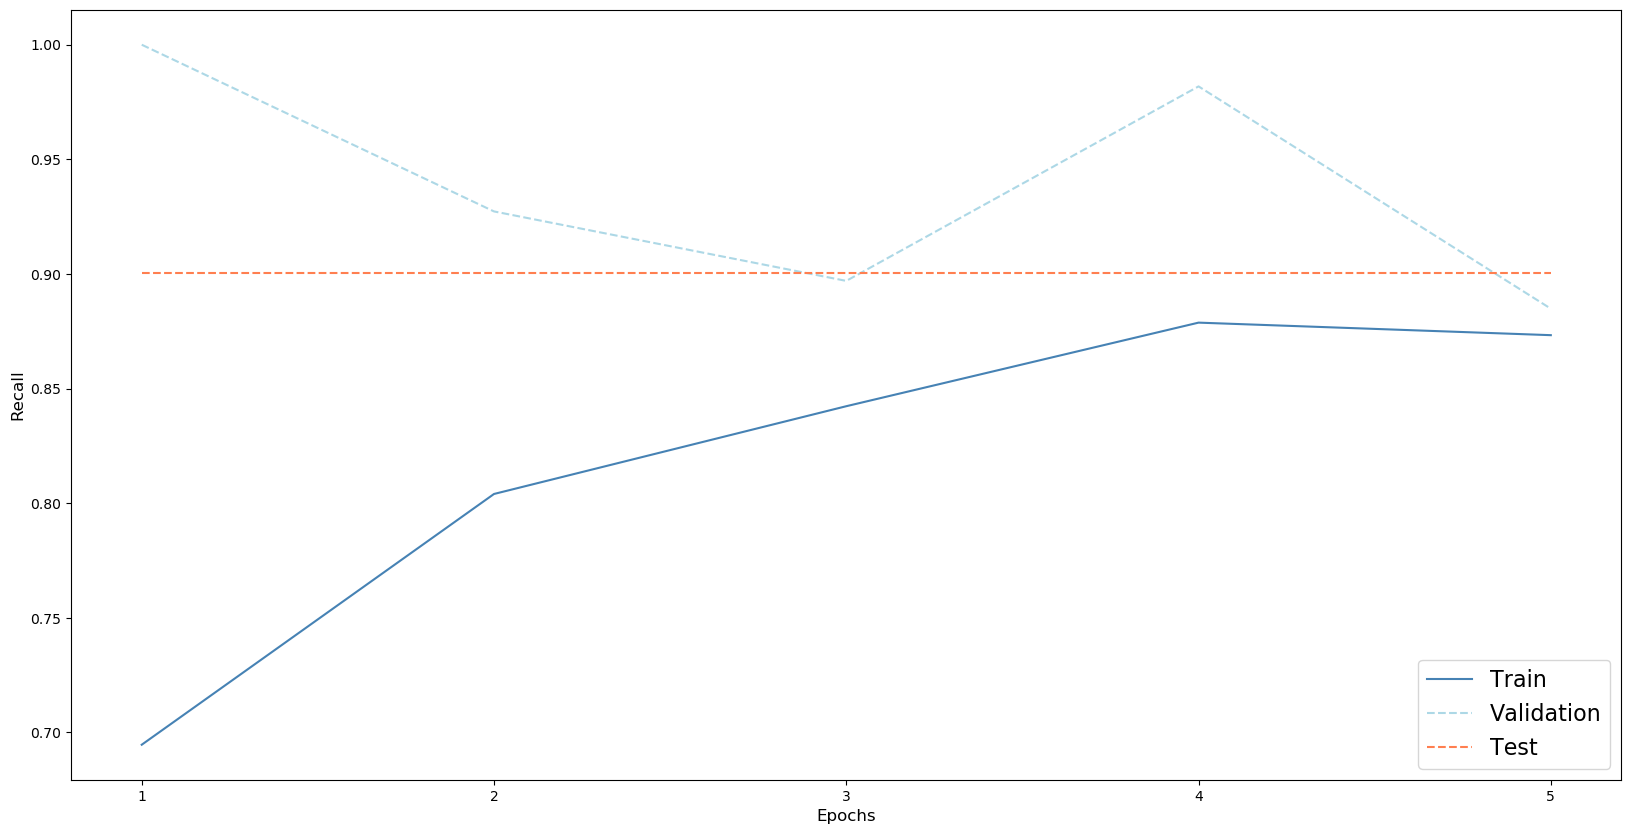

In [ ]:
test_recalls_list = test_recalls * model.epochs
epochs = [i for i in range(1,model.epochs+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_list, color= "coral", ls='dashed', label='Test')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
# ax.set_title("Recall", fontsize=16)
plt.show()

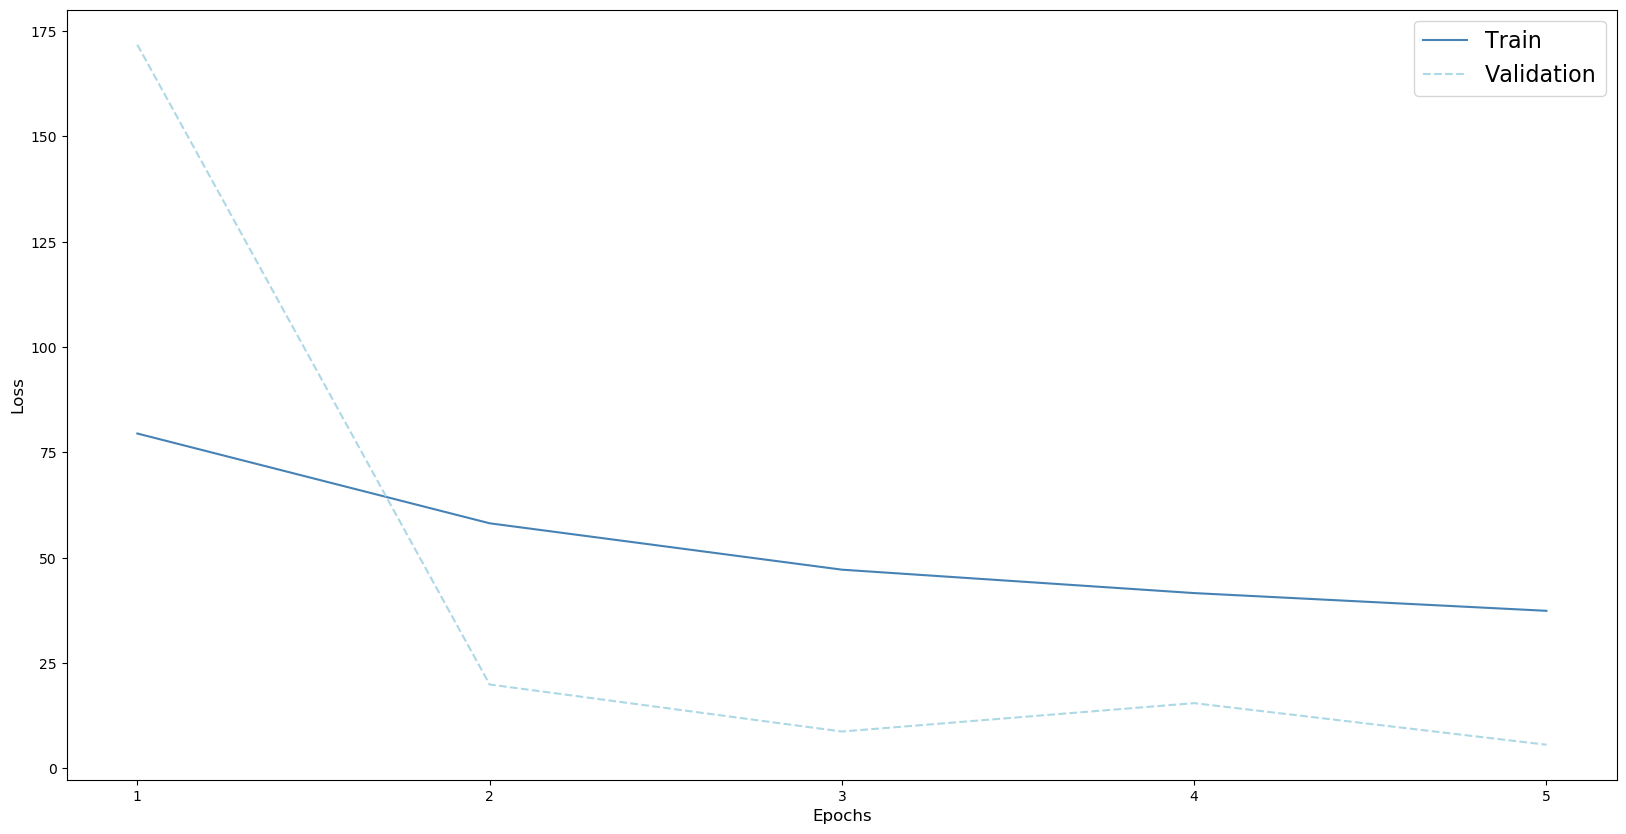

In [ ]:
epochs = [i for i in range(1,model.epochs+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_losses, color="steelblue", label= 'Train')
ax.plot(epochs, val_losses, color="lightblue", ls='dashed', label='Validation')
ax.set_xticks(epochs)
ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Loss", fontsize=16)
plt.show()

In [ ]:
print(val_accuracies)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[0.28448275862068967, 0.7482758620689656, 0.9275862068965517, 0.8068965517241379, 0.9344827586206896]
[1.0, 0.9272727272727272, 0.896969696969697, 0.9818181818181818, 0.8848484848484849]
0.0: 415
1.0: 165
